In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.pyplot as plt

2023-03-20 15:19:11.431459: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('/Users/theothormann/Desktop/Data Science/Projects/StocksRNN/PRTS.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-02-09,11.00,12.12,10.50,11.90,11.90,3146700
1,2007-02-12,11.85,12.45,11.40,11.84,11.84,346400
2,2007-02-13,11.95,12.03,11.59,11.92,11.92,123700
3,2007-02-14,11.90,11.90,11.60,11.60,11.60,75000
4,2007-02-15,11.83,11.83,11.40,11.60,11.60,188000


In [4]:
df1 = df.reset_index()['Low']

In [5]:
'''
np.where(pd.isnull(df1))
df1 = df1.dropna()
np.where(pd.isnull(df1))
'''

'\nnp.where(pd.isnull(df1))\ndf1 = df1.dropna()\nnp.where(pd.isnull(df1))\n'

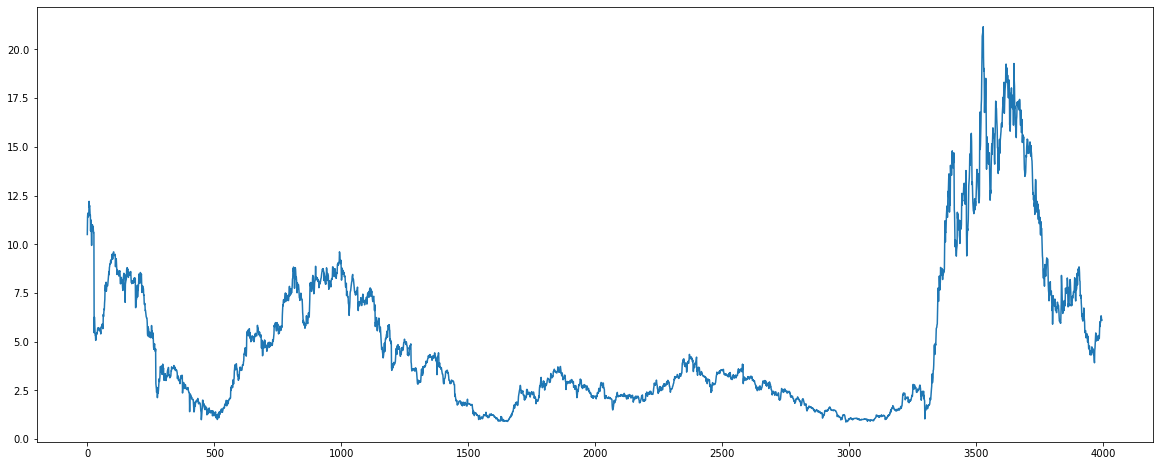

In [6]:
plt.figure(figsize=(20,8))
plt.plot(df1)

In [7]:
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
df1

array([[0.47435897],
       [0.51873767],
       [0.52810651],
       ...,
       [0.26577909],
       [0.25739645],
       [0.25739645]])

In [9]:
training_size=int(len(df1)*0.8)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [10]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
time_step=100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [12]:
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [13]:
X_train.shape[1]

100

In [14]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, activation = 'relu', return_sequences = True,  input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

2023-03-20 15:19:32.374956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-traina

In [16]:
model.fit(X_train, y_train, epochs=20, batch_size=64, shuffle=False)

Epoch 1/20
49/49 [==============================] - 8s 93ms/step - loss: 0.0093
Epoch 2/20
49/49 [==============================] - 4s 90ms/step - loss: 0.0080
Epoch 3/20
49/49 [==============================] - 6s 117ms/step - loss: 0.0050
Epoch 4/20
49/49 [==============================] - 5s 103ms/step - loss: 0.0021
Epoch 5/20
49/49 [==============================] - 5s 110ms/step - loss: 8.5218e-04
Epoch 6/20
49/49 [==============================] - 6s 120ms/step - loss: 7.7996e-04
Epoch 7/20
49/49 [==============================] - 6s 120ms/step - loss: 7.4283e-04
Epoch 8/20
49/49 [==============================] - 5s 97ms/step - loss: 7.0353e-04
Epoch 9/20
49/49 [==============================] - 5s 94ms/step - loss: 7.0481e-04
Epoch 10/20
49/49 [==============================] - 5s 102ms/step - loss: 5.7930e-04
Epoch 11/20
49/49 [==============================] - 5s 95ms/step - loss: 5.3983e-04
Epoch 12/20
49/49 [==============================] - 5s 97ms/step - loss: 4.8379e-04

In [17]:
test_predict = model.predict(X_test)

22/22 [==============================] - 1s 19ms/step


In [18]:
print(f'MSE {mean_squared_error(y_test, test_predict)}')
print(f'R2 {r2_score(y_test, test_predict)}')

MSE 0.07793778791020001
R2 -0.4848738628576643


In [19]:
test_predict= scaler.inverse_transform(test_predict)
train_predict = model.predict(X_train)
train_predict=scaler.inverse_transform(train_predict)

97/97 [==============================] - 2s 19ms/step


In [20]:
#y_test=scaler.inverse_transform(y_test.reshape(-1, 1))

In [21]:
look_back = 100

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

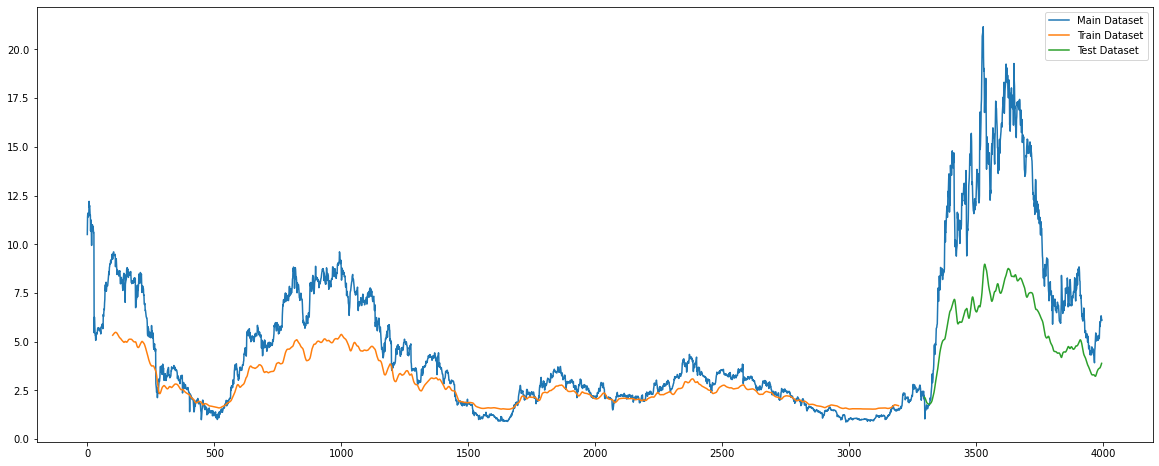

In [22]:
plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(df1), label = 'Main Dataset')
plt.plot(trainPredictPlot, label = 'Train Dataset')
plt.plot(testPredictPlot, label = 'Test Dataset')
plt.legend()

In [23]:
x_input = df1[len(df1)-100:].reshape(1,-1)

In [24]:
x_input = x_input.reshape((1,100,1))
y_predict = model.predict(x_input, verbose = 0)
next_day_value = scaler.inverse_transform(y_predict)

In [25]:
next_day_value

array([[3.9686003]], dtype=float32)